# Conv-6 CNN: CIFAR-10 & TensorFlow-2.8

In [1]:
# Specify GPU to be used-
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES = 0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [2]:
import tensorflow
from tensorflow import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle, os, time
import math

from tqdm import tqdm
from tqdm import trange

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K

from tensorflow.keras.layers import AveragePooling2D, Conv2D, MaxPooling2D, ReLU
from tensorflow.keras import models, layers, datasets
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from tensorflow.keras.layers import Layer, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.initializers import RandomNormal, Constant

# from sklearn.metrics import accuracy_score, precision_score, recall_score

In [3]:
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.8.0


In [4]:
# Check GPU availibility-
gpu_devices = tf.config.list_physical_devices('GPU')
# print(f"GPU: {gpu_devices}")

if gpu_devices:
    print(f"GPU: {gpu_devices}")
    details = tf.config.experimental.get_device_details(gpu_devices[0])
    print(f"GPU details: {details.get('device_name', 'Unknown GPU')}")
else:
    print("No GPU found")

GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU details: NVIDIA GeForce RTX 3080


2022-03-22 16:35:55.004237: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-22 16:35:55.024151: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-22 16:35:55.024267: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-22 16:35:55.025234: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [5]:
# Specify hyper-parameters
batch_size = 64
num_classes = 10
num_epochs = 80

# weight_decay = 0.0005
weight_decay = 0.001

### CIFAR-10 Data Pre-processing

In [6]:
# Data preprocessing and cleaning:
# input image dimensions
img_rows, img_cols = 32, 32

# Load CIFAR-10 dataset-
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Load CIFAR-100 dataset-
# (X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar100.load_data()

In [7]:
if tf.keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 3, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 3, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 3)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)

print("\n'input_shape' which will be used = {0}\n".format(input_shape))


'input_shape' which will be used = (32, 32, 3)



In [8]:
# Convert datasets to floating point types-
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Normalize the training and testing datasets-
X_train /= 255.0
X_test /= 255.0

In [9]:
# convert class vectors/target to binary class matrices or one-hot encoded values-
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [10]:
print("\nDimensions of training and testing sets are:")
print("X_train.shape = {0}, y_train.shape = {1}".format(X_train.shape, y_train.shape))
print("X_test.shape = {0}, y_test.shape = {1}".format(X_test.shape, y_test.shape))


Dimensions of training and testing sets are:
X_train.shape = (50000, 32, 32, 3), y_train.shape = (50000, 10)
X_test.shape = (10000, 32, 32, 3), y_test.shape = (10000, 10)


In [11]:
print(f"There are {len(X_train) / batch_size} training steps in one epoch")

There are 781.25 training steps in one epoch


In [12]:
print(f"In {num_epochs} epochs there are {num_epochs * (len(X_train) / batch_size)} training steps/iterations")

In 80 epochs there are 62500.0 training steps/iterations


### Prepare CIFAR10 dataset for TensorFlow _GradientTape_ training:

In [13]:
# Create training and testing datasets-
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

2022-03-22 16:35:58.035666: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-22 16:35:58.036340: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-22 16:35:58.036533: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-22 16:35:58.036625: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [14]:
train_dataset = train_dataset.shuffle(buffer_size = 20000, reshuffle_each_iteration = True).batch(batch_size = batch_size, drop_remainder = False)

In [15]:
test_dataset = test_dataset.batch(batch_size = batch_size, drop_remainder = False)

In [16]:
# Choose loss function for training-
loss_fn = tf.keras.losses.CategoricalCrossentropy()

optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01, momentum = 0.9)

In [17]:
# Select metrics to measure the error & accuracy of model.
# These metrics accumulate the values over epochs and then
# print the overall result-
train_loss = tf.keras.metrics.Mean(name = 'train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name = 'train_accuracy')

test_loss = tf.keras.metrics.Mean(name = 'test_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name = 'test_accuracy')

### Define _Conv-6_ CNN architecture

In [19]:
class ConvBlock(Model):
    def __init__(self, num_filters, use_four_layers = False):
        super(ConvBlock, self).__init__()
        self.use_four_layers = use_four_layers
        
        self.conv1 = Conv2D(
            filters = num_filters, kernel_size = (3, 3),
            activation = None, kernel_initializer = tf.keras.initializers.he_normal(),
            strides = (1, 1), padding = 'same',
            use_bias = False, kernel_regularizer = regularizers.l2(weight_decay)
        )
        self.bn1 = BatchNormalization(
            momentum = 0.99, epsilon = 0.001,
            beta_initializer = RandomNormal(mean = 0.0, stddev = 0.05),
            gamma_initializer = Constant(value = 0.9)
        )
        
        self.conv2 = Conv2D(
            filters = num_filters, kernel_size = (3, 3),
            activation = None, kernel_initializer = tf.keras.initializers.he_normal(),
            strides = (1, 1), padding = 'same',
            use_bias = False, kernel_regularizer = regularizers.l2(weight_decay)
        )
        self.bn2 = BatchNormalization(
            momentum = 0.99, epsilon = 0.001,
            beta_initializer = RandomNormal(mean = 0.0, stddev = 0.05),
            gamma_initializer = Constant(value = 0.9)
        )
        
        if use_four_layers:
            self.conv3 = Conv2D(
                filters = num_filters, kernel_size = (3, 3),
                activation = None, kernel_initializer = tf.keras.initializers.he_normal(),
                strides = (1, 1), padding = 'same',
                use_bias = False, kernel_regularizer = regularizers.l2(weight_decay)
            )
            self.bn3 = BatchNormalization(
                momentum = 0.99, epsilon = 0.001,
                beta_initializer = RandomNormal(mean = 0.0, stddev = 0.05),
                gamma_initializer = Constant(value = 0.9)
            )
            
            self.conv4 = Conv2D(
                filters = num_filters, kernel_size = (3, 3),
                activation = None, kernel_initializer = tf.keras.initializers.he_normal(),
                strides = (1, 1), padding = 'same',
                use_bias = False, kernel_regularizer = regularizers.l2(weight_decay)
            )
            self.bn4 = BatchNormalization(
                momentum = 0.99, epsilon = 0.001,
                beta_initializer = RandomNormal(mean = 0.0, stddev = 0.05),
                gamma_initializer = Constant(value = 0.9)
            )
        
        self.pool = MaxPooling2D(
            pool_size = (2, 2),
            strides = (2, 2)
        )
    
    
    def call(self, x):
        # x = tf.keras.activations.relu(self.bn1(self.conv1(x)))
        x = tf.nn.relu(self.bn1(self.conv1(x)))
        x = tf.nn.relu(self.bn2(self.conv2(x)))
        if self.use_four_layers:
            x = tf.nn.relu(self.bn3(self.conv3(x)))
            x = tf.nn.relu(self.bn4(self.conv4(x)))
            
        return self.pool(x)
    
    
    def shape_computation(self, x):
        print(f"Input shape: {x.shape}")
        x = self.conv1(x)
        print(f"Conv1 output shape: {x.shape}")
        x = self.conv2(x)
        print(f"Conv2 output shape: {x.shape}")
        
        if self.use_four_layers:
            x = self.conv3(x)
            print(f"Conv3 output shape: {x.shape}")
            x = self.conv4(x)
            print(f"Conv4 output shape: {x.shape}")
        
        x = self.pool(x)
        print(f"Pool output shape: {x.shape}")
        del x
        return None
    
    

In [20]:
class Conv6(Model):
    def __init__(self):
        super(Conv6, self).__init__()
        
        self.conv_block1 = ConvBlock(num_filters = 64, use_four_layers = False)
        self.conv_block2 = ConvBlock(num_filters = 128, use_four_layers = False)
        self.conv_block3 = ConvBlock(num_filters = 256, use_four_layers = True)

        self.flatten = Flatten()
        
        self.dense1 = Dense(
            units = 256, activation = None,
            kernel_initializer = tf.keras.initializers.he_normal(),
            use_bias = False, bias_initializer = 'ones'
        )
        self.bn1 = BatchNormalization(
            momentum = 0.99, epsilon = 0.001,
            beta_initializer = RandomNormal(mean = 0.0, stddev = 0.05),
            gamma_initializer = Constant(value = 0.9)
        )
        
        self.dense2 = Dense(
            units = 256, activation = None,
            kernel_initializer = tf.keras.initializers.he_normal(),
            use_bias = False, bias_initializer = 'ones'
        )
        self.bn2 = BatchNormalization(
            momentum = 0.99, epsilon = 0.001,
            beta_initializer = RandomNormal(mean = 0.0, stddev = 0.05),
            gamma_initializer = Constant(value = 0.9)
        )
        
        self.out = Dense(
            units = 10, activation = None,
            use_bias = True, bias_initializer = 'ones'
        )
    
    
    def call(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.flatten(x)
        x = tf.nn.relu(self.bn1(self.dense1(x)))
        x = tf.nn.relu(self.bn2(self.dense2(x)))
        x = tf.nn.softmax(self.out(x))
        return x
    
    
    def shape_computation(self, x):
        print(f"Input shape: {x.shape}")
        x = self.conv_block1(x)
        print(f"conv_block1 output shape: {x.shape}")
        x = self.conv_block2(x)
        print(f"conv_block2 output shape: {x.shape}")
        x = self.conv_block3(x)
        print(f"conv_block3 output shape: {x.shape}")
        x = self.flatten(x)
        print(f"flattened output shape: {x.shape}")
        x = self.dense1(x)
        print(f"dense1 output shape: {x.shape}")
        x = self.dense2(x)
        print(f"dense2 output shape: {x.shape}")
        x = self.out(x)
        print(f"Output shape: {x.shape}")
        del x
        return None
    
    
    def model(self):
        '''
        Overrides 'model()' call.
        Output shape is not well-defined when using sub-classing. As a
        workaround, this method is implemeted.
        '''
        x = Input(shape = (32, 32, 3))
        return Model(inputs = [x], outputs = self.call(x))
        
        

In [21]:
# Initialize an instance of Conv-6 CNN-
model = Conv6()
# model.build(input_shape = (None, 32, 32, 3))

In [22]:
# Sanity check-
x, y = next(iter(train_dataset))

In [23]:
pred = model(x)

2022-03-22 16:36:57.313145: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8302
2022-03-22 16:36:58.170358: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [24]:
pred.shape, y.shape

(TensorShape([64, 10]), TensorShape([64, 10]))

In [25]:
model.shape_computation(x)

Input shape: (64, 32, 32, 3)
conv_block1 output shape: (64, 16, 16, 64)
conv_block2 output shape: (64, 8, 8, 128)
conv_block3 output shape: (64, 4, 4, 256)
flattened output shape: (64, 4096)
dense1 output shape: (64, 256)
dense2 output shape: (64, 256)
Output shape: (64, 10)


In [26]:
del x, y, pred

In [27]:
# Save current weights-
model.save_weights("Conv6_random_weights.h5", overwrite = True)

In [ ]:
# model.load_weights("Conv6_random_weights.h5")

In [28]:
# Get CNN model summary-
model.model().summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv_block (ConvBlock)      (None, 16, 16, 64)        39104     
                                                                 
 conv_block_1 (ConvBlock)    (None, 8, 8, 128)         222208    
                                                                 
 conv_block_2 (ConvBlock)    (None, 4, 4, 256)         2068480   
                                                                 
 flatten (Flatten)           (None, 4096)              0         
                                                                 
 dense (Dense)               (None, 256)               1048576   
                                                                 
 batch_normalization_8 (Batc  (None, 256)              1024  

In [29]:
# Count number of trainable parameters in VGG-18 model-
tot_params = 0

for layer in model.trainable_weights:
    loc_params = tf.math.count_nonzero(layer, axis = None).numpy()
    print(f"layer: {layer.shape} has {loc_params} params")
    tot_params += loc_params

layer: (3, 3, 3, 64) has 1728 params
layer: (64,) has 64 params
layer: (64,) has 64 params
layer: (3, 3, 64, 64) has 36864 params
layer: (64,) has 64 params
layer: (64,) has 64 params
layer: (3, 3, 64, 128) has 73728 params
layer: (128,) has 128 params
layer: (128,) has 128 params
layer: (3, 3, 128, 128) has 147456 params
layer: (128,) has 128 params
layer: (128,) has 128 params
layer: (3, 3, 128, 256) has 294912 params
layer: (256,) has 256 params
layer: (256,) has 256 params
layer: (3, 3, 256, 256) has 589824 params
layer: (256,) has 256 params
layer: (256,) has 256 params
layer: (3, 3, 256, 256) has 589824 params
layer: (256,) has 256 params
layer: (256,) has 256 params
layer: (3, 3, 256, 256) has 589824 params
layer: (256,) has 256 params
layer: (256,) has 256 params
layer: (4096, 256) has 1048576 params
layer: (256,) has 256 params
layer: (256,) has 256 params
layer: (256, 256) has 65536 params
layer: (256,) has 256 params
layer: (256,) has 256 params
layer: (256, 10) has 2560 par

In [29]:
print(f"Conv-6 has {tot_params} trainable parameters")

Conv-6 has 3444682 trainable parameters


In [30]:
import tensorflow.keras.backend as K


# METHOD-1: This also counts biases
trainable_wts = np.sum([K.count_params(w) for w in model.trainable_weights])
non_trainable_wts = np.sum([K.count_params(w) for w in model.non_trainable_weights])

print("\nNumber of training weights = {0} and non-trainable weights = {1}\n".format(
    trainable_wts, non_trainable_wts
))
print("Total number of parameters = {0}\n".format(trainable_wts + non_trainable_wts))



Number of training weights = 3444682 and non-trainable weights = 3840

Total number of parameters = 3448522



In [31]:
print("\nAccording to tf.keras.backend: Number of training weights = {0}, non-trainabel weights = {1} and total number of parameters = {2}\n".format(
    trainable_wts, non_trainable_wts, (trainable_wts + non_trainable_wts)
))

print("According to tf.math.count_nonzero() method, total number of trainable weights = {0}\n".format(tot_params))


According to tf.keras.backend: Number of training weights = 3444682, non-trainabel weights = 3840 and total number of parameters = 3448522

According to tf.math.count_nonzero() method, total number of trainable weights = 3444682



### Mask Creation

__Create masks only for trainable layer(s)/parameter(s).__

In [32]:
def create_first_mask_np(model):
    # Function to create numpy masks of all 1s
    # using TF2 neural network 'model' as input.
    
    # Python3 list to contain masks-
    mask_model = []
    
    # Iterate through the model and for each trainable layer,
    # initialize all parameters to 1-
    for layer in model.trainable_weights:
        m = np.ones_like(layer, dtype = np.int8)
        mask_model.append(m)
        
    return mask_model


In [33]:
# Sanity check-
mask_model = create_first_mask_np(model = model)

In [34]:
# Sanity check-
for layer, x in zip(model.trainable_weights, mask_model):
    print(f"layer.shape: {layer.shape}, mask.shape: {x.shape}")


layer.shape: (3, 3, 3, 64), mask.shape: (3, 3, 3, 64)
layer.shape: (64,), mask.shape: (64,)
layer.shape: (64,), mask.shape: (64,)
layer.shape: (3, 3, 64, 64), mask.shape: (3, 3, 64, 64)
layer.shape: (64,), mask.shape: (64,)
layer.shape: (64,), mask.shape: (64,)
layer.shape: (3, 3, 64, 128), mask.shape: (3, 3, 64, 128)
layer.shape: (128,), mask.shape: (128,)
layer.shape: (128,), mask.shape: (128,)
layer.shape: (3, 3, 128, 128), mask.shape: (3, 3, 128, 128)
layer.shape: (128,), mask.shape: (128,)
layer.shape: (128,), mask.shape: (128,)
layer.shape: (3, 3, 128, 256), mask.shape: (3, 3, 128, 256)
layer.shape: (256,), mask.shape: (256,)
layer.shape: (256,), mask.shape: (256,)
layer.shape: (3, 3, 256, 256), mask.shape: (3, 3, 256, 256)
layer.shape: (256,), mask.shape: (256,)
layer.shape: (256,), mask.shape: (256,)
layer.shape: (3, 3, 256, 256), mask.shape: (3, 3, 256, 256)
layer.shape: (256,), mask.shape: (256,)
layer.shape: (256,), mask.shape: (256,)
layer.shape: (3, 3, 256, 256), mask.shap

In [35]:
def count_nonzero_masks(mask_model):
    '''
    Function to count non-zero masks using Python3 'mask_model'
    as input.
    '''
    
    tot_masks = 0
    for x in mask_model:
        loc_masks = np.count_nonzero(x)
        tot_masks += loc_masks
        # print(f"mask.shape: {x.shape} has {np.count_nonzero(x)} masks")
        
    return tot_masks


In [36]:
def count_nonzero_params(model):
    '''
    Function to count non-zero trainable parameters using
    TF2 'model' as input.
    '''
    
    tot_params = 0
    
    for layer in model.trainable_weights:
        loc_params = tf.math.count_nonzero(layer, axis = None).numpy()
        tot_params += loc_params
    
    return tot_params


In [37]:
# Sanity check-
print(f"Conv-6 has {count_nonzero_params(model)} trainable parameters"
      f" & {count_nonzero_masks(mask_model)} masks"
     )

Conv-6 has 3444682 trainable parameters & 3444682 masks


### Image Augmentation using _ImageDataGenerator_:

Refer-
[tf.keras.preprocessing.image.ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

In [38]:
# Example of using 'tf.keras.preprocessing.image import ImageDataGenerator class's - flow(x, y)':
datagen = ImageDataGenerator(
    # featurewise_center=True,
    # featurewise_std_normalization=True,
    rotation_range = 15,
    width_shift_range = 0.1, # 0.2
    height_shift_range = 0.1, # 0.2
    horizontal_flip = True
)


# flow():
# Takes data & label arrays, generates batches of augmented data.

# datagen.flow(X_train, y_train, batch_size=batch_size, shuffle=True)

In [39]:
# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(X_train)

### Train neural network with _tf.GradientTape()_ and _masks_

In [40]:
@tf.function
def train_one_step(model, mask_model, optimizer, x, y):
    '''
    Compute one training step/iteration of gradient descent optimization.
    
    Input arguments-
    1. model - TF2 model
    2. mask_model - Python3 list containing np arrays of type int8
    3. optimizer - gradient descent optimizer
    '''
    
    with tf.GradientTape() as tape:
        # Predict with defined model-
        pred = model(x)
        
        # Compute loss-
        loss = loss_fn(y, pred)
        
    # Compute gradients wrt defined loss and weights & biases-
    grads = tape.gradient(loss, model.trainable_variables)
    
    # type(grads)-
    # list
    
    # List to hold element-wise multiplication between-
    # computed gradient and masks-
    grad_mask_mul = []
    
    # Perform element-wise multiplication between computed gradients and masks-
    '''
    for grad_layer, mask in zip(grads, mask_model.trainable_weights):
        grad_mask_mul.append(tf.math.multiply(grad_layer, mask))
    '''
    for grad_layer, mask in zip(grads, mask_model):
        grad_mask_mul.append(
            tf.math.multiply(
                grad_layer, tf.cast(x = mask, dtype = tf.float32)
                # grad_layer, tf.convert_to_tensor(value = mask, dtype = tf.float32)
            )
        )
    
    # Apply computed gradients to model's weights and biases-
    optimizer.apply_gradients(zip(grad_mask_mul, model.trainable_variables))
    
    # Compute metrics-
    train_loss(loss)
    train_accuracy(y, pred)
    
    return None
    

In [41]:
@tf.function
def test_step(model, optimizer, data, labels):
    '''
    Compute (trained) model performance on testing dataset
    '''
    
    # Make predictions-
    predictions = model(data)
    
    # Compute loss-
    t_loss = loss_fn(labels, predictions)

    # Compute metrics-
    test_loss(t_loss)
    test_accuracy(labels, predictions)

    return None


In [42]:
# User input parameters for Early Stopping in manual implementation-
minimum_delta = 0.001
patience = 5

In [43]:
# Initialize parameters for Early Stopping manual implementation-
best_val_acc = 0
loc_patience = 0    

In [44]:
# Python3 dict to contain training metrics-
train_hist = {}

In [45]:
print(f"Train model for {num_epochs} epochs")

Train model for 80 epochs


In [46]:
for epoch in range(num_epochs):
    
    if loc_patience >= patience:
        print("\n'EarlyStopping' called!\n")
        break
    
    
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
    
    # variable to keep track of current training step-
    curr_step = 0
    
    # Train using data augmentation (ImageDataGenerator())-
    for x, y in datagen.flow(X_train, y_train, batch_size = batch_size, shuffle = True):
        train_one_step(model, mask_model, optimizer, x, y)
        # print("current step = ", curr_step)
        curr_step += 1
        
        # break out of infinite loop to end current training epoch-
        if curr_step >= X_train.shape[0] // batch_size:
            # print("\nTerminating training (datagen.flow())")
            break

    # Testing dataset-
    for x_t, y_t in test_dataset:
        test_step(model, optimizer, x_t, y_t)
    
    print(f"\nEpoch = {epoch + 1}; loss = {train_loss.result().numpy():.4f}, accuracy = {train_accuracy.result().numpy() * 100:.3f}%",
          f" val loss = {test_loss.result().numpy():.4f}, val acc = {test_accuracy.result().numpy() * 100:.3f}%"
          f" LR = {optimizer._decayed_lr('float32').numpy():.6f} & step_val = {optimizer.iterations.numpy()}"
         )
    
    train_hist[epoch + 1] = {
        'loss': train_loss.result().numpy(), 'acc': train_accuracy.result().numpy() * 100,
        'val_loss': test_loss.result().numpy(), 'val_acc': test_accuracy.result().numpy() * 100,
        'lr': optimizer._decayed_lr('float32').numpy(), 'step_val': optimizer.iterations.numpy()
    }

    # Count number of non-zero parameters in each layer and in total-
    print(f"Conv-6: total # of trainable parameters = {count_nonzero_params(model = model)}")
    
    
    # Insert manual implementation of code for early stopping here-
    if (test_accuracy.result() * 100 > best_val_acc) and (np.abs((test_accuracy.result() * 100) - best_val_acc) >= minimum_delta):

        # Update 'best_val_loss' variable to lowest loss encountered so far-
        # best_val_loss = test_loss.result()
        
        # Update best val acc to highest val acc so far-
        best_val_acc = test_accuracy.result() * 100
        
        # reset 'loc_patience' variable-
        loc_patience = 0

        # print(f"Saving model with lowest val_loss = {test_loss.result():.4f}\n")
        print(f"Saving model with highest val_acc = {best_val_acc:.3f}%\n")
        
        # Save trained model with 'best' validation loss-
        # model.save_weights("Conv6_best_val_loss.h5", overwrite = True)
        
        # Save trained model with 'best' validation accuracy-
        model.save_weights("Conv6_best_val_acc.h5", overwrite = True)
    
    # There is no improvement in monitored metric 'val_loss'-
    else:
        # number of epochs without any improvement-
        loc_patience += 1
        
    
   


Epoch = 1; loss = 1.7534, accuracy = 35.201%  val loss = 1.3642, val acc = 50.750% LR = 0.010000 & step_val = 781
Conv-6: total # of trainable parameters = 3444682
Saving model with highest val_acc = 50.750%


Epoch = 2; loss = 1.2914, accuracy = 53.035%  val loss = 1.1095, val acc = 60.940% LR = 0.010000 & step_val = 1562
Conv-6: total # of trainable parameters = 3444682
Saving model with highest val_acc = 60.940%


Epoch = 3; loss = 1.0685, accuracy = 62.062%  val loss = 0.9038, val acc = 68.570% LR = 0.010000 & step_val = 2343
Conv-6: total # of trainable parameters = 3444682
Saving model with highest val_acc = 68.570%


Epoch = 4; loss = 0.9214, accuracy = 67.444%  val loss = 0.7826, val acc = 72.720% LR = 0.010000 & step_val = 3124
Conv-6: total # of trainable parameters = 3444682
Saving model with highest val_acc = 72.720%


Epoch = 5; loss = 0.8165, accuracy = 71.297%  val loss = 0.6819, val acc = 76.780% LR = 0.010000 & step_val = 3905
Conv-6: total # of trainable parameters =

In [47]:
# Sanity check-
count_nonzero_params(model), count_nonzero_masks(mask_model)

(3444682, 3444682)

In [48]:
# Further sanity check-
for layer in model.weights:
    print(f"layer: {layer.shape}, type: {type(layer)}")

layer: (3, 3, 3, 64), type: <class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>
layer: (64,), type: <class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>
layer: (64,), type: <class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>
layer: (64,), type: <class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>
layer: (64,), type: <class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>
layer: (3, 3, 64, 64), type: <class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>
layer: (64,), type: <class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>
layer: (64,), type: <class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>
layer: (64,), type: <class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>
layer: (64,), type: <class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>
layer: (3, 3, 64, 128), type: <class 'tensorflow.python.ops.resource_vari

In [49]:
# Further sanity check-
for layer in mask_model:
    print(f"layer: {layer.shape}, type: {type(layer)}")

layer: (3, 3, 3, 64), type: <class 'numpy.ndarray'>
layer: (64,), type: <class 'numpy.ndarray'>
layer: (64,), type: <class 'numpy.ndarray'>
layer: (3, 3, 64, 64), type: <class 'numpy.ndarray'>
layer: (64,), type: <class 'numpy.ndarray'>
layer: (64,), type: <class 'numpy.ndarray'>
layer: (3, 3, 64, 128), type: <class 'numpy.ndarray'>
layer: (128,), type: <class 'numpy.ndarray'>
layer: (128,), type: <class 'numpy.ndarray'>
layer: (3, 3, 128, 128), type: <class 'numpy.ndarray'>
layer: (128,), type: <class 'numpy.ndarray'>
layer: (128,), type: <class 'numpy.ndarray'>
layer: (3, 3, 128, 256), type: <class 'numpy.ndarray'>
layer: (256,), type: <class 'numpy.ndarray'>
layer: (256,), type: <class 'numpy.ndarray'>
layer: (3, 3, 256, 256), type: <class 'numpy.ndarray'>
layer: (256,), type: <class 'numpy.ndarray'>
layer: (256,), type: <class 'numpy.ndarray'>
layer: (3, 3, 256, 256), type: <class 'numpy.ndarray'>
layer: (256,), type: <class 'numpy.ndarray'>
layer: (256,), type: <class 'numpy.ndarr

### Visualize training metrics

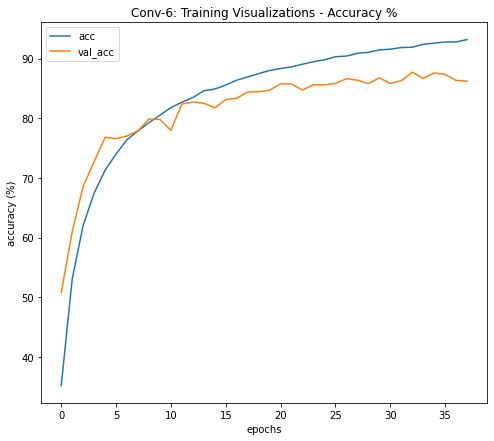

In [51]:
# Visualizations-
plt.figure(figsize = (8, 7))
plt.plot([train_hist[x]['acc'] for x in train_hist.keys()], label = 'acc')
plt.plot([train_hist[x]['val_acc'] for x in train_hist.keys()], label = 'val_acc')
plt.xlabel("epochs")
plt.ylabel("accuracy (%)")
plt.title("Conv-6: Training Visualizations - Accuracy %")
plt.legend(loc = "best")
plt.show()

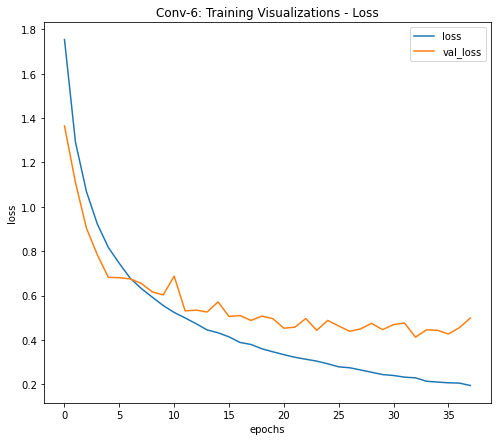

In [52]:
# Visualizations-
plt.figure(figsize = (8, 7))
plt.plot([train_hist[x]['loss'] for x in train_hist.keys()], label = 'loss')
plt.plot([train_hist[x]['val_loss'] for x in train_hist.keys()], label = 'val_loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Conv-6: Training Visualizations - Loss")
plt.legend(loc = "best")
plt.show()

In [53]:
# Save training metrics as pickled object-
with open("Conv6_training_history.pkl", "wb") as file:
    pickle.dump(train_hist, file)

In [54]:
# Sanity check- Initialize and load weights from before-
best_model = Conv6()
best_model.build(input_shape = (None, 32, 32, 3))

In [55]:
best_model.load_weights("Conv6_best_val_acc.h5")

In [56]:
# Compile model-
best_model.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01, momentum = 0.9),
    metrics=['accuracy']
)

In [57]:
# Get validation metrics on validation dataset-
val_loss, val_acc = best_model.evaluate(x = X_test, y = y_test)

313/313 [==============================] - 1s 2ms/step - loss: 5.2869 - accuracy: 0.8770


In [58]:
print("Trained Conv-6 CNN validataion metrics: loss"
      f" = {val_loss:.4f} & accuracy = {val_acc * 100:.3f}%")

Trained Conv-6 CNN validataion metrics: loss = 5.2869 & accuracy = 87.700%


In [59]:
del model, best_model, mask_model